# Attention Pooling by Similarity

> 个人理解把pooling翻译成汇聚比翻译成池化要好很多

- 这个笔记对理解注意力比较重要

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

## Kernals and Data

$$
\begin{split}\begin{aligned}
\alpha(\mathbf{q}, \mathbf{k}) & = \exp\left(-\frac{1}{2} \|\mathbf{q} - \mathbf{k}\|^2 \right) && \textrm{Gaussian;} \\
\alpha(\mathbf{q}, \mathbf{k}) & = 1 \textrm{ if } \|\mathbf{q} - \mathbf{k}\| \leq 1 && \textrm{Boxcar;} \\
\alpha(\mathbf{q}, \mathbf{k}) & = \mathop{\mathrm{max}}\left(0, 1 - \|\mathbf{q} - \mathbf{k}\|\right) && \textrm{Epanechikov.}
\end{aligned}\end{split}
$$

Note:

- 这三种核都是为了刻画相似度的，q和k越相似，值越大
- 我们可以看到上面经过核操作的值全部为非负数
- 而且需要注意的是，注意力矩阵并不是一个对称的矩阵

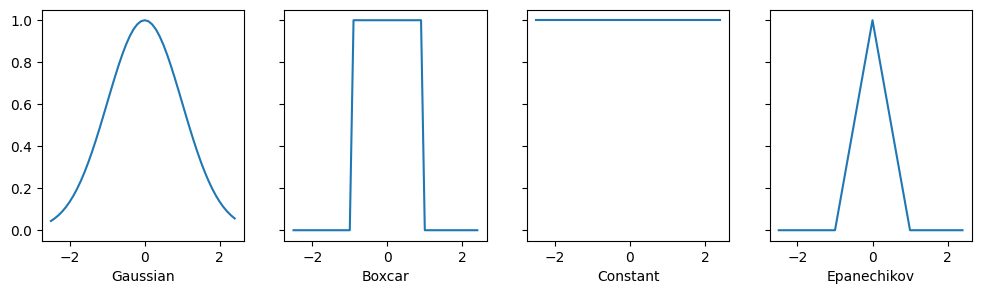

In [2]:
# Define some kernels
def gaussian(x):
    return torch.exp(-x**2 / 2)

def boxcar(x):
    return torch.abs(x) < 1.0

def constant(x):
    return 1.0 + 0 * x

def epanechikov(x):
    return torch.max(1 - torch.abs(x), torch.zeros_like(x))

fig, axes = d2l.plt.subplots(
    1, 4, 
    sharey=True, 
    figsize=(12, 3)
)

kernels = (gaussian, boxcar, constant, epanechikov)
names = ('Gaussian', 'Boxcar', 'Constant', 'Epanechikov')
x = torch.arange(-2.5, 2.5, 0.1)
for kernel, name, ax in zip(kernels, names, axes):
    ax.plot(
        x.detach().numpy(), 
        kernel(x).detach().numpy()
    )
    ax.set_xlabel(name)

d2l.plt.show()

## Generate data

$$
y_i = 2\sin(x_i) + x_i + \epsilon,
$$

In [3]:
n_train = 50  # 训练样本数
x_train, _ = torch.sort(torch.rand(n_train) * 5)   # 排序后的训练样本

def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  # 训练样本的输出
x_val = torch.arange(0, 5, 0.1)  # 测试样本
y_val = f(x_val)  # 测试样本的真实输出
n_val = len(x_val)  # 测试样本数
n_val

50

## Attention Pooling via Nadaraya–Watson Regression

- here x_train is the `key`, x_val is the `query`
- y_train is the `value`
- note that the 3 above are all 1D vectors

$$
f(\mathbf{q}) = \sum_i \mathbf{v}_i \frac{\alpha(\mathbf{q}, \mathbf{k}_i)}{\sum_j \alpha(\mathbf{q}, \mathbf{k}_j)}.
$$

we can write it in matrix form

$$
f(\mathbf{q}) = \mathbf{V} \times \frac{\alpha(\mathbf{q}, \mathbf{k})}{\alpha(\mathbf{q}, \mathbf{k})\mathrm{.sum}(\mathrm{dim} = 1)},
$$



In [4]:
import torch.nn.functional as F

def nadaraya_watson(x_train, y_train, x_val, kernel):
    # 计算训练集和验证集之间的距离矩阵
    dists = x_train.reshape((-1, 1)) - x_val.reshape((1, -1))
    # 计算核矩阵，每一列对应一个查询点，每一行对应一个键点
    k = kernel(dists).type(torch.float32)
    # 对每个查询点，计算其对所有键点的注意力权重
    attention_w = k / k.sum(0) # 这里也可以使用softmax
    # attention_w = F.softmax(k, dim=0) # 但是效果不如上面的好
    # 计算每个查询点的预测值，即所有键点的加权平均值
    y_hat = y_train @ attention_w
    # 返回预测值和注意力权重
    return y_hat, attention_w

In [5]:
def plot(x_train, y_train, x_val, y_val, kernels, names, attention=False):
    # 创建一个1行4列的图像，共享y轴，设置图像大小为12x3
    fig, axes = d2l.plt.subplots(
        1, 4, 
        sharey=True, 
        figsize=(12, 3)
    )
    # 遍历核函数、名称和子图
    for kernel, name, ax in zip(kernels, names, axes):
        # 调用 nadaraya_watson 函数，计算预测值和注意力权重
        y_hat, attention_w = nadaraya_watson(
            x_train, y_train, x_val, 
            kernel
        )
        # 如果 attention 为 True，则绘制注意力权重热力图
        if attention:
            pcm = ax.imshow(
                attention_w.detach().numpy(), 
                cmap='Reds'
            )
        # 如果 attention 为 False，则绘制预测值和真实值的曲线图
        else:
            ax.plot(x_val, y_hat)
            ax.plot(x_val, y_val, 'm--')
            ax.plot(x_train, y_train, 'o', alpha=0.5)
        # 设置子图的x轴标签为名称
        ax.set_xlabel(name)
        # 如果 attention 为 False，则设置子图的图例
        if not attention:
            ax.legend(['y_hat', 'y'])
    # 如果 attention 为 True，则添加颜色条
    if attention:
        fig.colorbar(pcm, ax=axes, shrink=0.7)

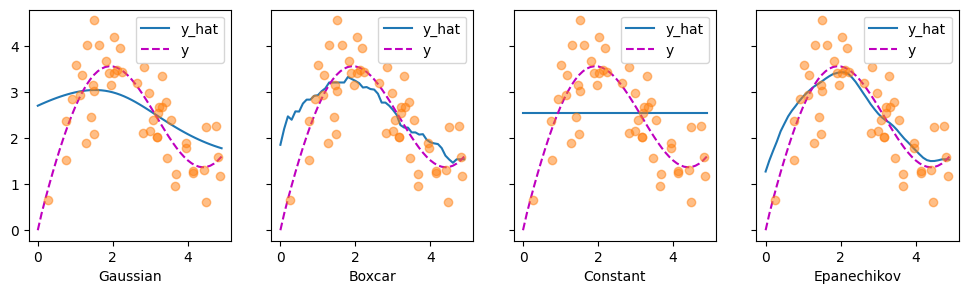

In [6]:
plot(
    x_train, y_train, 
    x_val, y_val, 
    kernels, names
)

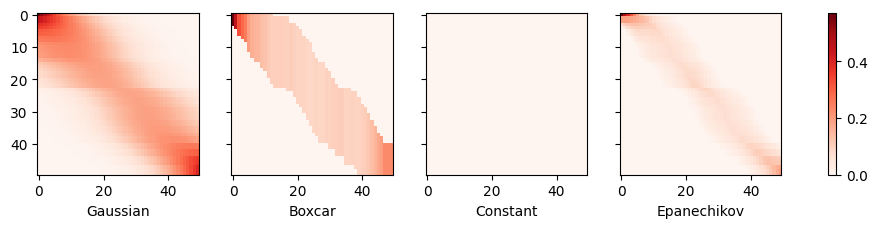

In [7]:
plot(
    x_train, y_train, 
    x_val, y_val, 
    kernels, names,
    attention=True
)

## Adapting Attention Pooling

$$
\alpha(\mathbf{q}, \mathbf{k}) = \exp\left(-\frac{1}{2 \sigma^2} \|\mathbf{q} - \mathbf{k}\|^2 \right)
$$

In [8]:
sigmas = (0.1, 0.2, 0.5, 1)
names = ['Sigma ' + str(sigma) for sigma in sigmas]

def gaussian_with_width(sigma):
    return (lambda x: torch.exp(-x**2 / (2*sigma**2)))

kernels = [gaussian_with_width(sigma) for sigma in sigmas]

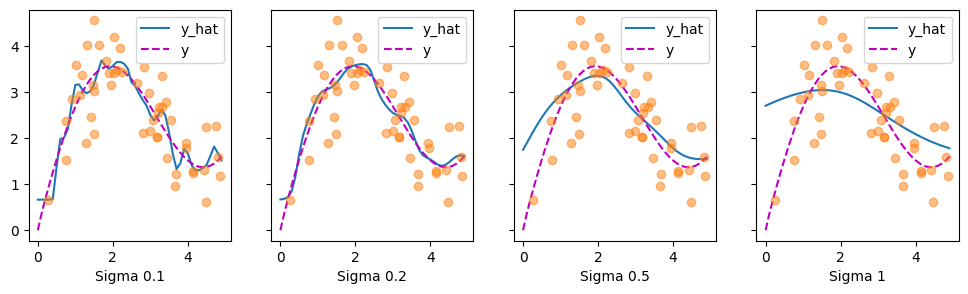

In [9]:
plot(
    x_train, y_train, 
    x_val, y_val, 
    kernels, names
)

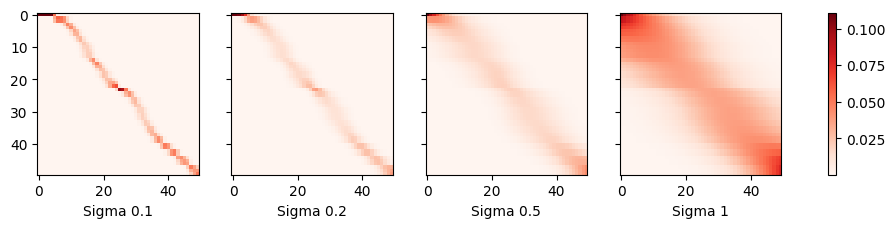

In [10]:
plot(
    x_train, y_train, 
    x_val, y_val, 
    kernels, names,
    attention=True
)

## Summary

可以看到从左到右，注意力越不够集中，拟合效果从过拟合慢慢变成了欠拟合。而且也可以看到，我们的网络所谓的训练也只是经过了矩阵的乘法就得到了注意力的集中；
而且我们也发现了，在这种回归问题中我们没有通过解方程或者训练网络的形式，就是通过和之前数据的相似度这一点得到了我们的预测值。

## More

### Use softmax to normalize

$$
\text{Softmax}(x_{i}) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}
$$

我们来探讨一下如果Nadaraya–Watson Regression中的归一化那里我们使用softmax会怎么样；

> 从最后的结果可以看到采用`k / k.sum(0)`的形式，会导致注意力的集中度不够，但更容易导致过拟合的效果出现，也就是说拟合效果更好；而采用`F.softmax(k, dim = 0)`的形式，会导致注意力的集中度较高，但拟合效果不如之前好；

In [11]:
kernal = gaussian_with_width(0.1)

In [12]:
# 计算训练集和验证集之间的距离矩阵
dists = x_train.reshape((-1, 1)) - x_val.reshape((1, -1))
dists

tensor([[ 0.2618,  0.1618,  0.0618,  ..., -4.4382, -4.5382, -4.6382],
        [ 0.7577,  0.6577,  0.5577,  ..., -3.9423, -4.0423, -4.1423],
        [ 0.7651,  0.6651,  0.5651,  ..., -3.9349, -4.0349, -4.1349],
        ...,
        [ 4.7570,  4.6570,  4.5570,  ...,  0.0570, -0.0430, -0.1430],
        [ 4.8138,  4.7138,  4.6138,  ...,  0.1138,  0.0138, -0.0862],
        [ 4.8522,  4.7522,  4.6522,  ...,  0.1522,  0.0522, -0.0478]])

In [13]:
# 计算核矩阵，每一列对应一个查询点，每一行对应一个键点
k = kernel(dists).type(torch.float32)
# 对每个查询点，计算其对所有键点的注意力权重，注意这里使用的是 softmax 函数
attention_w = F.softmax(k, dim=0)
attention_w1 = k / k.sum(0)
# 计算每个查询点的预测值，即所有键点的加权平均值
y_hat = y_train @ attention_w
y_hat1 = y_train @ attention_w1

In [14]:
attention_w

tensor([[0.0405, 0.0441, 0.0480,  ..., 0.0168, 0.0170, 0.0174],
        [0.0246, 0.0269, 0.0292,  ..., 0.0168, 0.0170, 0.0174],
        [0.0245, 0.0267, 0.0290,  ..., 0.0168, 0.0170, 0.0174],
        ...,
        [0.0193, 0.0191, 0.0188,  ..., 0.0432, 0.0443, 0.0411],
        [0.0193, 0.0191, 0.0188,  ..., 0.0408, 0.0456, 0.0435],
        [0.0193, 0.0191, 0.0188,  ..., 0.0393, 0.0439, 0.0452]])

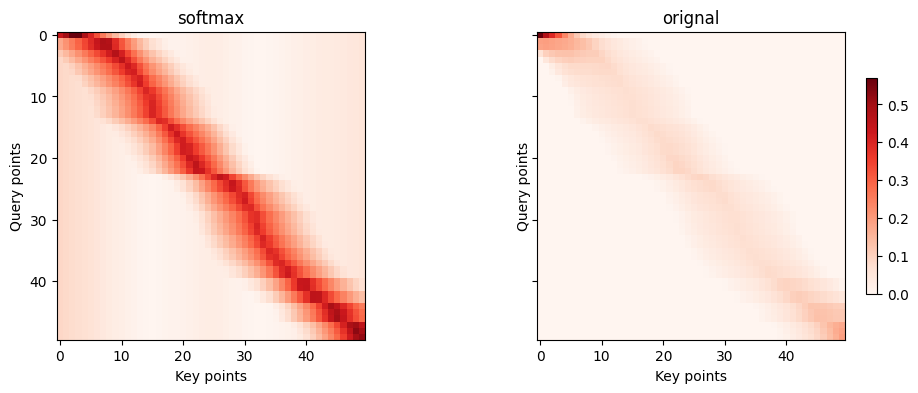

In [15]:
fig, axes = d2l.plt.subplots(
    1, 2, 
    sharey=True, 
    figsize=(12, 4)
)

for ax, attention_w, names in zip(axes, (attention_w, attention_w1), ('softmax', 'orignal')):
    pcm = ax.imshow(
        attention_w.detach().numpy(), 
        cmap='Reds'
    )
    ax.set_xlabel('Key points')
    ax.set_ylabel('Query points')
    ax.set_title(names)

fig.colorbar(pcm, shrink=0.7)


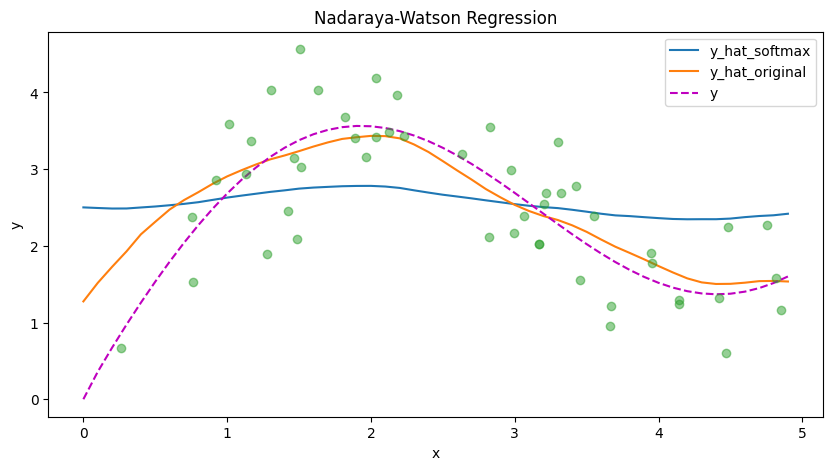

In [16]:
fig = d2l.plt.figure(figsize=(10, 5))

d2l.plt.plot(x_val, y_hat)
d2l.plt.plot(x_val, y_hat1)
d2l.plt.plot(x_val, y_val, 'm--')
d2l.plt.plot(x_train, y_train, 'o', alpha=0.5)

d2l.plt.legend(['y_hat_softmax', 'y_hat_original', 'y'])

d2l.plt.xlabel('x')
d2l.plt.ylabel('y')
d2l.plt.title('Nadaraya-Watson Regression')
d2l.plt.show()

### Nadaraya–Watson Regression with Gaussian Kernels

$$
\begin{split}\begin{aligned}
\alpha(\mathbf{q}, \mathbf{k}) & = \exp\left(-\frac{1}{2} \|\mathbf{q} - \mathbf{k}\|^2 \right) 
&& \textrm{Gaussian;} \\
\alpha(\mathbf{q}, \mathbf{k}) & = \exp\left(-\frac{1}{2 \sigma^2} \|\mathbf{q} - \mathbf{k}\|^2 \right)
&& \textrm{Adapting Gaussian;} 
\end{aligned}\end{split}
$$

我们可以看到上面两个不同的核函数都是对应高斯分布。

下面不妨把上述第一个式子代入Nadaraya–Watson Regression中，我们可以得到

$$
\begin{split}\begin{aligned} 
f(x) &=\sum_{i=1}^n \alpha(x, x_i) y_i\\ 
&= \sum_{i=1}^n \frac{\exp\left(-\frac{1}{2}(x - x_i)^2\right)}{\sum_{j=1}^n \exp\left(-\frac{1}{2}(x - x_j)^2\right)} y_i \\
&= \sum_{i=1}^n \mathrm{softmax}\left(-\frac{1}{2}(x - x_i)^2\right) y_i. 
\end{aligned}\end{split}
$$

写成矩阵形式

$$
\hat{y} = f(x) = \mathbf{y}_\mathrm{train}^\top \mathrm{softmax}\left(-\frac{1}{2}(x - \mathbf{x}_\mathrm{train})^2\right).
$$

感觉到这里，对注意力的理解又清晰了不少。